# Data Analytics for Health - Task 2.3: Hierarchical Clustering Analysis

## Overview
This notebook performs hierarchical clustering analysis on the prepared patient profile:
- 2.3.1: Compare different clustering results using different versions of the algorithm
- 2.3.2: Show and discuss different dendrograms using different algorithms

## Objectives
- Compare different linkage methods (ward, complete, average, single)
- Visualize dendrograms for different algorithms
- Analyze cluster characteristics for different approaches
- Select optimal number of clusters and linkage method

---


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")


Libraries imported successfully
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data
Plots directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/plots


## 1. Load Prepared Patient Profile


In [16]:
# Load prepared patient profile
df = pd.read_csv(data_path / '1.2.2_prepared_patient_profile.csv')

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")

# Prepare data for clustering
X = df[numeric_features].copy()
subject_ids = df['subject_id'].copy()

# Handle any remaining NaN values
print(f"\nNaN values before handling: {X.isna().sum().sum()}")
X = X.fillna(X.mean())
print(f"NaN values after handling: {X.isna().sum().sum()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features, index=X.index)

print(f"\nData prepared for clustering: {X_scaled_df.shape}")

# For hierarchical clustering with large datasets, we may need to sample
# Uncomment the following lines if the dataset is too large (>5000 samples)
# sample_size = 2000
# sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
# X_scaled = X_scaled[sample_indices]
# print(f"Sampled to {len(X_scaled)} samples for hierarchical clustering")


Loaded patient profile: 4,392 subjects × 14 features

Numeric features for clustering: 12

NaN values before handling: 4001
NaN values after handling: 0

Data prepared for clustering: (4392, 12)


## 2.3.1 Compare Different Clustering Results Using Different Algorithms

### Test Different Linkage Methods


In [17]:
# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters_range = range(2, 11)  # Test different numbers of clusters

results = []

print("Testing different linkage methods and numbers of clusters...")
for linkage_method in linkage_methods:
    print(f"\n--- Testing {linkage_method.upper()} linkage ---")
    
    for n_clusters in n_clusters_range:
        try:
            clustering = AgglomerativeClustering(
                n_clusters=n_clusters, 
                linkage=linkage_method
            )
            labels = clustering.fit_predict(X_scaled)
            
            # Compute metrics
            silhouette = silhouette_score(X_scaled, labels)
            davies_bouldin = davies_bouldin_score(X_scaled, labels)
            calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
            
            results.append({
                'linkage': linkage_method,
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz
            })
            
            print(f"  k={n_clusters}: Silhouette={silhouette:.3f}, "
                  f"DB={davies_bouldin:.3f}, CH={calinski_harabasz:.2f}")
        except Exception as e:
            print(f"  k={n_clusters}: Error - {e}")

results_df = pd.DataFrame(results)


Testing different linkage methods and numbers of clusters...

--- Testing WARD linkage ---
  k=2: Silhouette=0.448, DB=1.485, CH=800.40
  k=3: Silhouette=0.272, DB=2.077, CH=683.13
  k=4: Silhouette=0.282, DB=1.740, CH=620.22
  k=5: Silhouette=0.288, DB=1.533, CH=596.31
  k=6: Silhouette=0.119, DB=1.702, CH=592.58
  k=7: Silhouette=0.131, DB=1.541, CH=587.96
  k=8: Silhouette=0.127, DB=1.493, CH=576.83
  k=9: Silhouette=0.119, DB=1.473, CH=557.80
  k=10: Silhouette=0.134, DB=1.426, CH=547.86

--- Testing COMPLETE linkage ---
  k=2: Silhouette=0.480, DB=1.190, CH=423.60
  k=3: Silhouette=0.442, DB=1.149, CH=248.04
  k=4: Silhouette=0.286, DB=2.037, CH=247.83
  k=5: Silhouette=0.251, DB=1.610, CH=275.88
  k=6: Silhouette=0.288, DB=1.582, CH=408.58
  k=7: Silhouette=0.234, DB=1.279, CH=431.92
  k=8: Silhouette=0.232, DB=1.471, CH=383.42
  k=9: Silhouette=0.231, DB=1.392, CH=339.33
  k=10: Silhouette=0.231, DB=1.414, CH=306.13

--- Testing AVERAGE linkage ---
  k=2: Silhouette=0.581, DB=0.

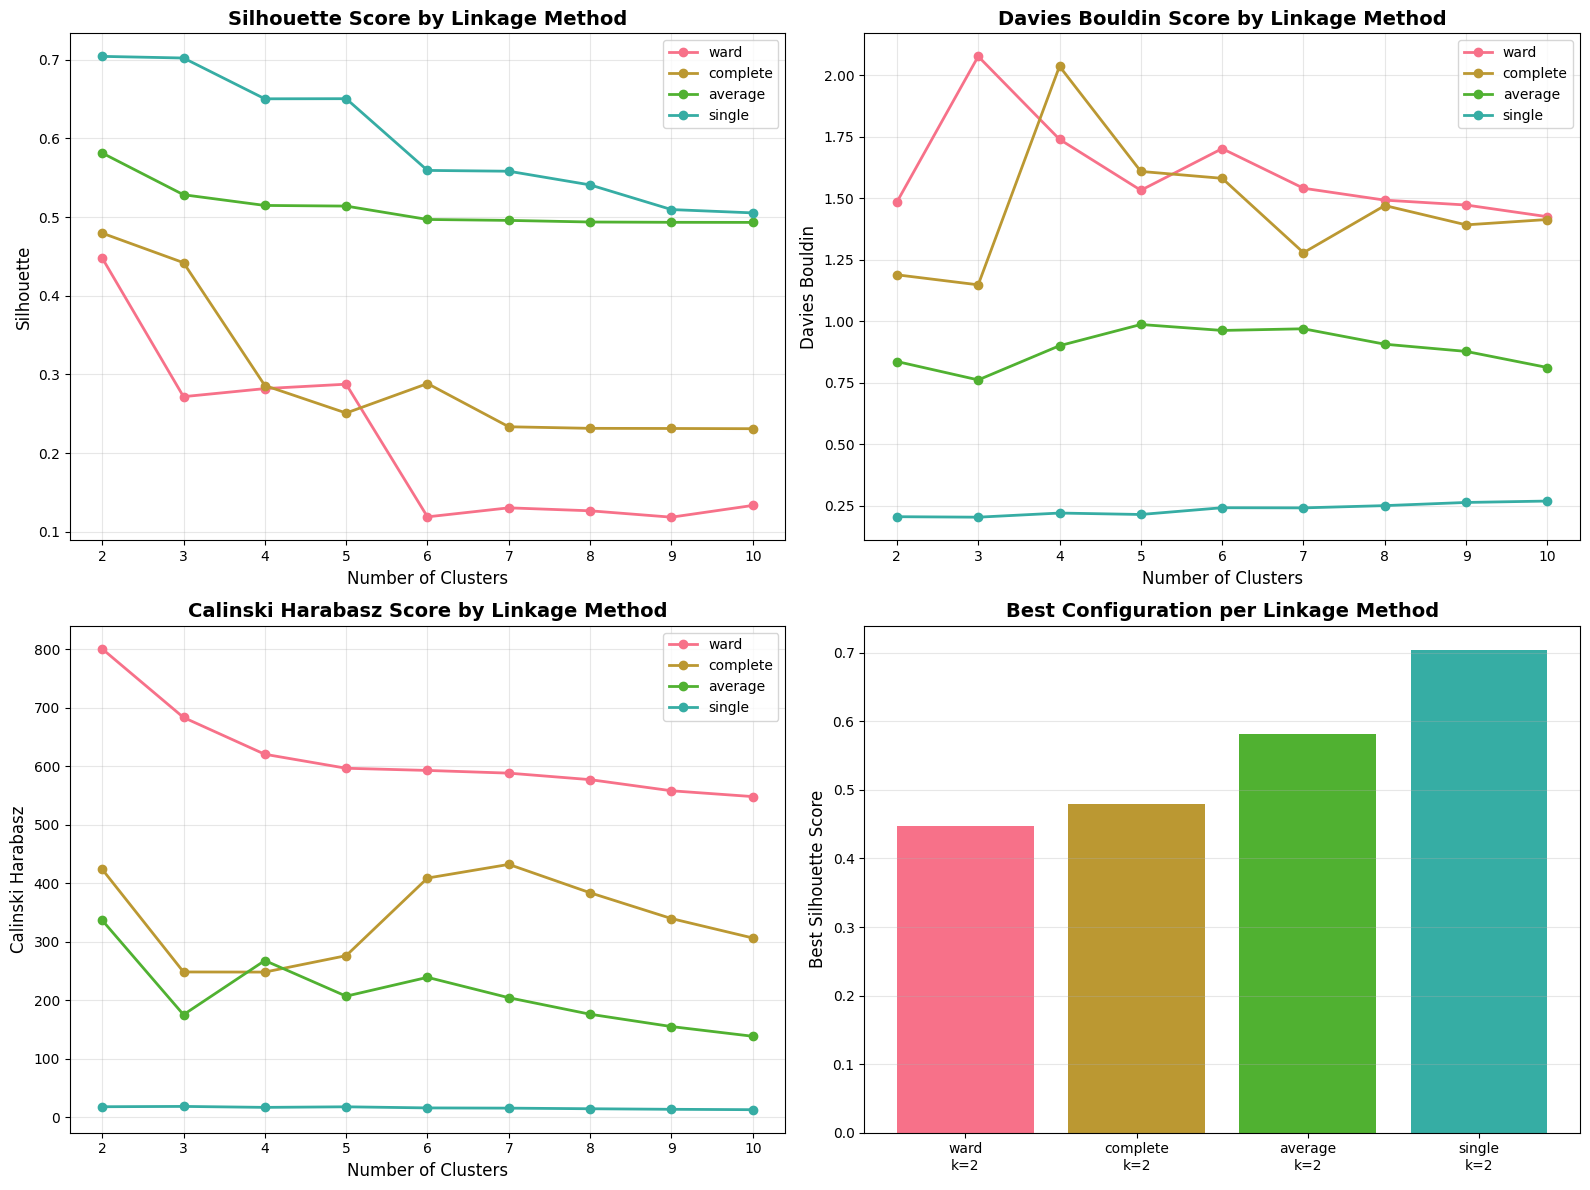


Best configuration for each linkage method:
 linkage  n_clusters  silhouette
    ward           2    0.447946
complete           2    0.479543
 average           2    0.581241
  single           2    0.704003


In [18]:
# Visualize comparison of linkage methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, metric in enumerate(['silhouette', 'davies_bouldin', 'calinski_harabasz']):
    ax = axes[idx // 2, idx % 2]
    
    for linkage_method in linkage_methods:
        method_data = results_df[results_df['linkage'] == linkage_method]
        ax.plot(method_data['n_clusters'], method_data[metric], 
               marker='o', label=linkage_method, linewidth=2, markersize=6)
    
    ax.set_xlabel('Number of Clusters', fontsize=12)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    ax.set_title(f'{metric.replace("_", " ").title()} Score by Linkage Method', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Find best combination for each metric
ax = axes[1, 1]
best_combinations = []
for linkage_method in linkage_methods:
    method_data = results_df[results_df['linkage'] == linkage_method]
    best_sil = method_data.loc[method_data['silhouette'].idxmax()]
    best_combinations.append({
        'linkage': linkage_method,
        'n_clusters': int(best_sil['n_clusters']),
        'silhouette': best_sil['silhouette']
    })
    ax.bar(f"{linkage_method}\nk={int(best_sil['n_clusters'])}", 
          best_sil['silhouette'], label=linkage_method)

ax.set_ylabel('Best Silhouette Score', fontsize=12)
ax.set_title('Best Configuration per Linkage Method', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(plots_dir / '2.3.1_linkage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBest configuration for each linkage method:")
best_df = pd.DataFrame(best_combinations)
print(best_df.to_string(index=False))


## 2.3.2 Show and Discuss Different Dendrograms

### Generate Dendrograms for Different Linkage Methods


In [19]:
# For dendrogram visualization, we may need to sample the data if it's too large
# Dendrograms become unreadable with too many points
max_samples_for_dendrogram = 100

if len(X_scaled) > max_samples_for_dendrogram:
    print(f"Sampling {max_samples_for_dendrogram} points for dendrogram visualization...")
    sample_indices = np.random.choice(len(X_scaled), max_samples_for_dendrogram, replace=False)
    X_scaled_dendro = X_scaled[sample_indices]
    print(f"Using {len(X_scaled_dendro)} samples for dendrogram")
else:
    X_scaled_dendro = X_scaled
    sample_indices = np.arange(len(X_scaled))

# Generate linkage matrices for different methods
linkage_matrices = {}
for linkage_method in linkage_methods:
    try:
        if linkage_method == 'ward':
            # Ward requires Euclidean distance
            Z = linkage(X_scaled_dendro, method=linkage_method, metric='euclidean')
        else:
            Z = linkage(X_scaled_dendro, method=linkage_method, metric='euclidean')
        linkage_matrices[linkage_method] = Z
        print(f"Generated linkage matrix for {linkage_method}")
    except Exception as e:
        print(f"Error generating linkage matrix for {linkage_method}: {e}")


Sampling 100 points for dendrogram visualization...
Using 100 samples for dendrogram
Generated linkage matrix for ward
Generated linkage matrix for complete
Generated linkage matrix for average
Generated linkage matrix for single


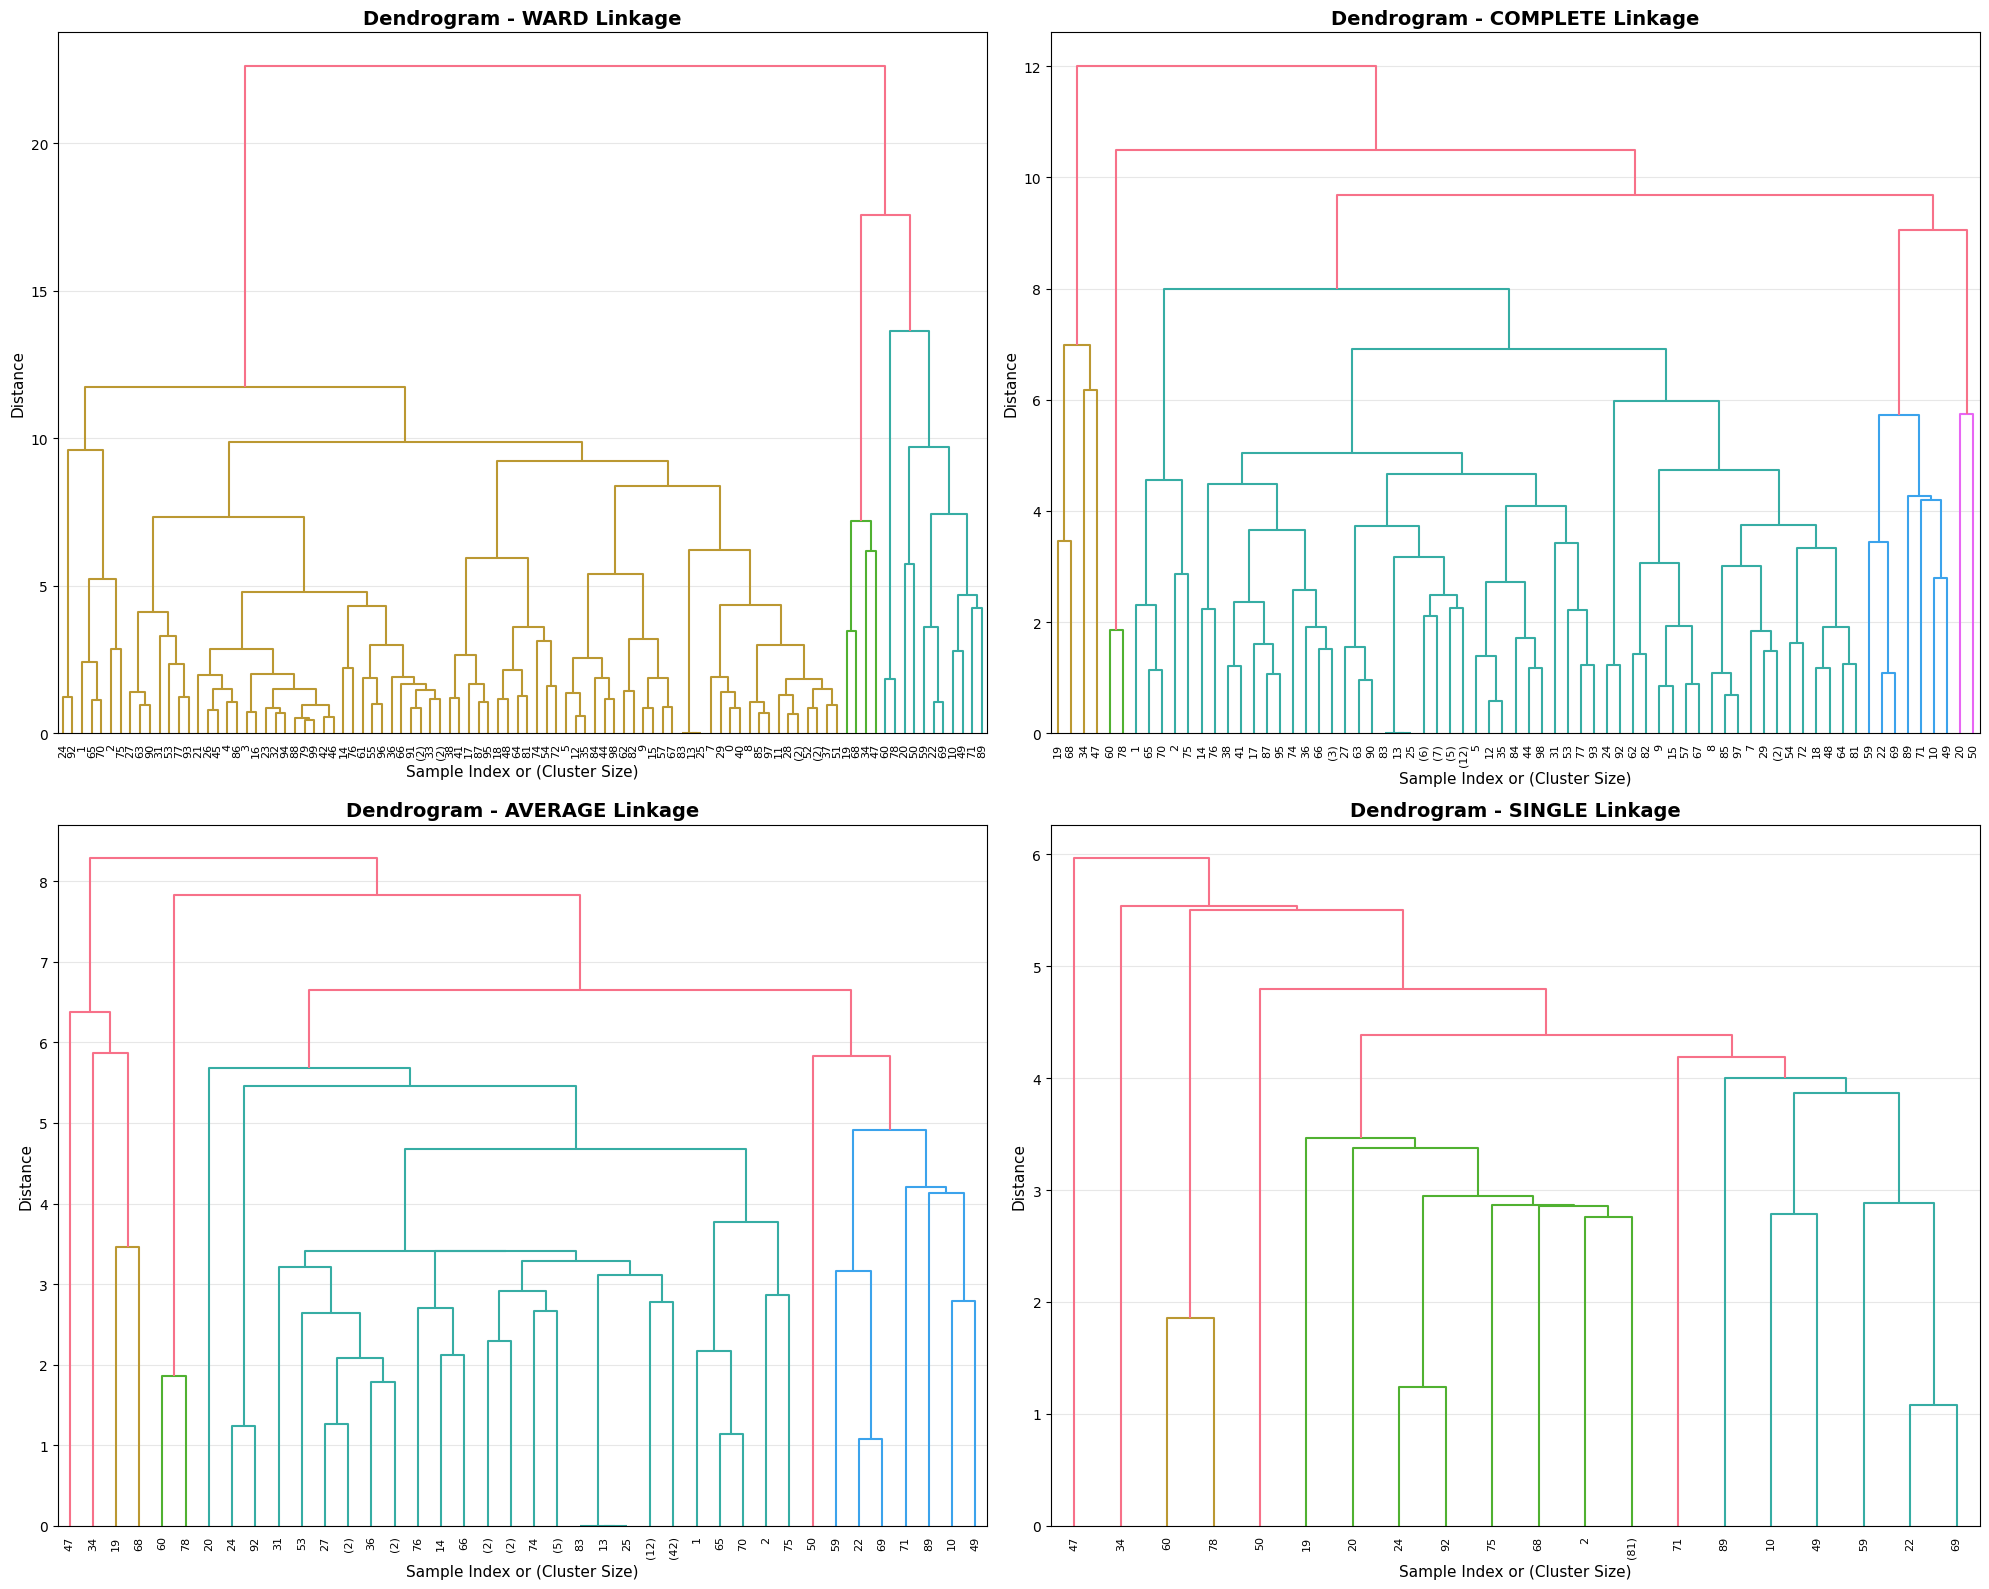

In [20]:
# Plot dendrograms for each linkage method
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, linkage_method in enumerate(linkage_methods):
    if linkage_method in linkage_matrices:
        Z = linkage_matrices[linkage_method]
        
        # Create dendrogram
        dendrogram(
            Z,
            ax=axes[idx],
            leaf_rotation=90,
            leaf_font_size=8,
            truncate_mode='level',
            p=10 if len(X_scaled_dendro) > 50 else None  # Show last 10 merged levels
        )
        
        axes[idx].set_title(f'Dendrogram - {linkage_method.upper()} Linkage', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Sample Index or (Cluster Size)', fontsize=11)
        axes[idx].set_ylabel('Distance', fontsize=11)
        axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_dendrograms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### Select Optimal Configuration and Perform Final Clustering


In [21]:
# Select best configuration (highest silhouette score)
best_config = results_df.loc[results_df['silhouette'].idxmax()]
optimal_linkage = best_config['linkage']
optimal_n_clusters = int(best_config['n_clusters'])

print("="*80)
print("OPTIMAL HIERARCHICAL CLUSTERING CONFIGURATION")
print("="*80)
print(f"Linkage method: {optimal_linkage}")
print(f"Number of clusters: {optimal_n_clusters}")
print(f"Silhouette score: {best_config['silhouette']:.4f}")
print(f"Davies-Bouldin score: {best_config['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz score: {best_config['calinski_harabasz']:.4f}")

# Perform final clustering with optimal parameters
hierarchical_final = AgglomerativeClustering(
    n_clusters=optimal_n_clusters,
    linkage=optimal_linkage
)
cluster_labels = hierarchical_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"\nCluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())

# Save clustered data
df_clustered.to_csv(data_path / '2.3_hierarchical_clustered_data.csv', index=False)
print(f"\nClustered data saved to: {data_path / '2.3_hierarchical_clustered_data.csv'}")


OPTIMAL HIERARCHICAL CLUSTERING CONFIGURATION
Linkage method: single
Number of clusters: 2
Silhouette score: 0.7040
Davies-Bouldin score: 0.2061
Calinski-Harabasz score: 17.6300

Cluster distribution:
cluster
0    4391
1       1
Name: count, dtype: int64

Clustered data saved to: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data/2.3_hierarchical_clustered_data.csv


### Cluster Characteristics Analysis


Cluster Characteristics (Mean Values):
   cluster  size  n_lab_events  n_micro_exam  total_procedures  n_diagnoses  \
0        0  4391         -0.00          0.00             -0.00        -0.00   
1        1     1          1.38         -0.51              0.53         2.29   

   n_positive_micro  abnormal_ratio  max_glucose  mean_creatinine  \
0               0.0           -0.00         0.00            -0.00   
1               0.0            0.36        -0.24             5.89   

   mean_hemoglobin   age  days_since_last_admission_x  n_total_admissions  
0            -0.00  0.00                        -0.01               -0.00  
1             0.51 -0.01                         3.58                2.54  


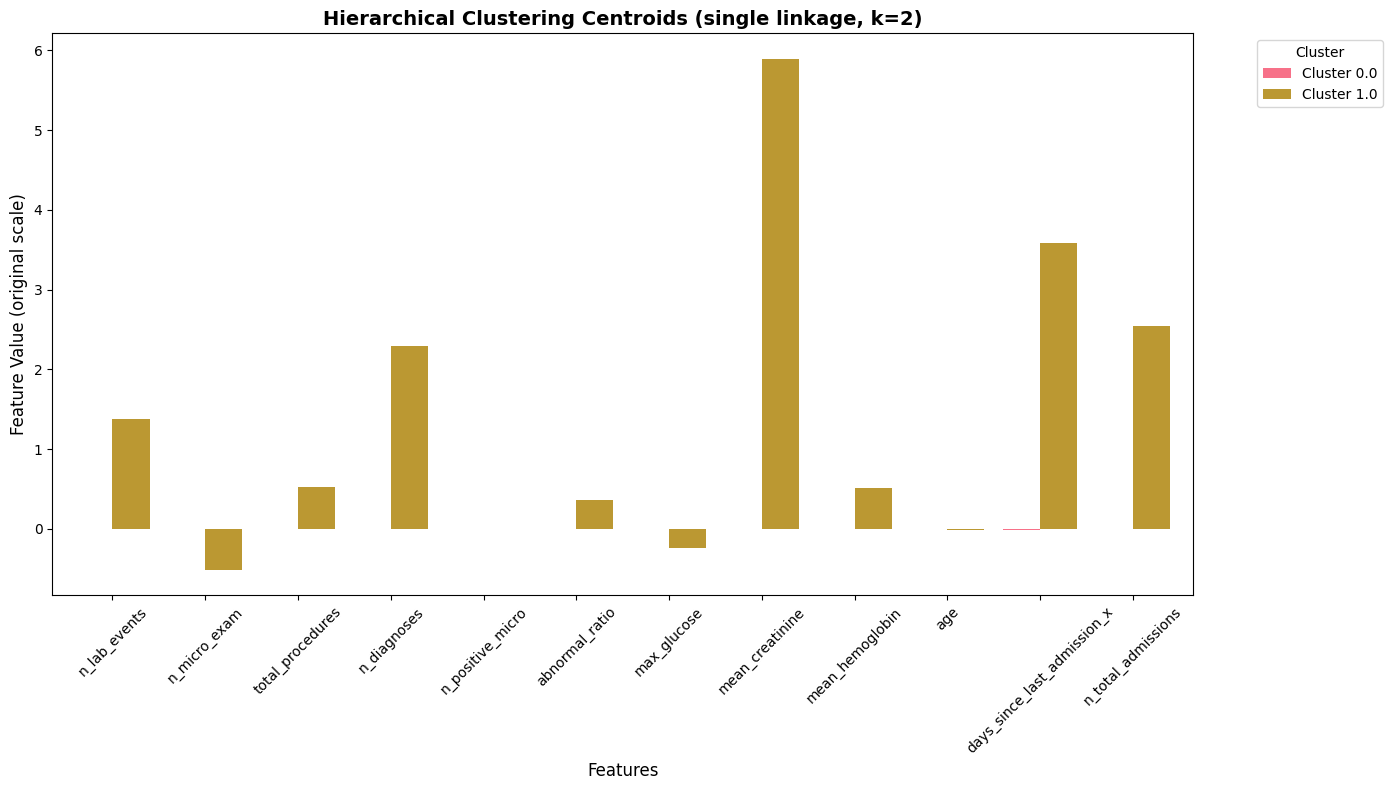

In [22]:
# Analyze cluster characteristics
cluster_stats = []
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    stats = {'cluster': cluster_id, 'size': len(cluster_data)}
    for feature in numeric_features:
        stats[f'{feature}_mean'] = cluster_data[feature].mean()
        stats[f'{feature}_std'] = cluster_data[feature].std()
    
    cluster_stats.append(stats)

cluster_stats_df = pd.DataFrame(cluster_stats)

# Display mean values for each cluster
print("Cluster Characteristics (Mean Values):")
mean_cols = [col for col in cluster_stats_df.columns if col.endswith('_mean')]
display_df = cluster_stats_df[['cluster', 'size'] + mean_cols].copy()
display_df.columns = ['cluster', 'size'] + [col.replace('_mean', '') for col in mean_cols]
print(display_df.round(2))

# Visualize cluster centroids
centroid_data = []
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    centroid = cluster_data[numeric_features].mean()
    centroid['cluster'] = cluster_id
    centroid_data.append(centroid)

centroids_df = pd.DataFrame(centroid_data)
centroids_df = centroids_df.set_index('cluster')
centroids_df.index = [f'Cluster {i}' for i in centroids_df.index]

# Plot centroids
fig, ax = plt.subplots(figsize=(14, 8))
centroids_df.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Feature Value (original scale)', fontsize=12)
ax.set_title(f'Hierarchical Clustering Centroids ({optimal_linkage} linkage, k={optimal_n_clusters})', 
            fontsize=14, fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_centroids_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


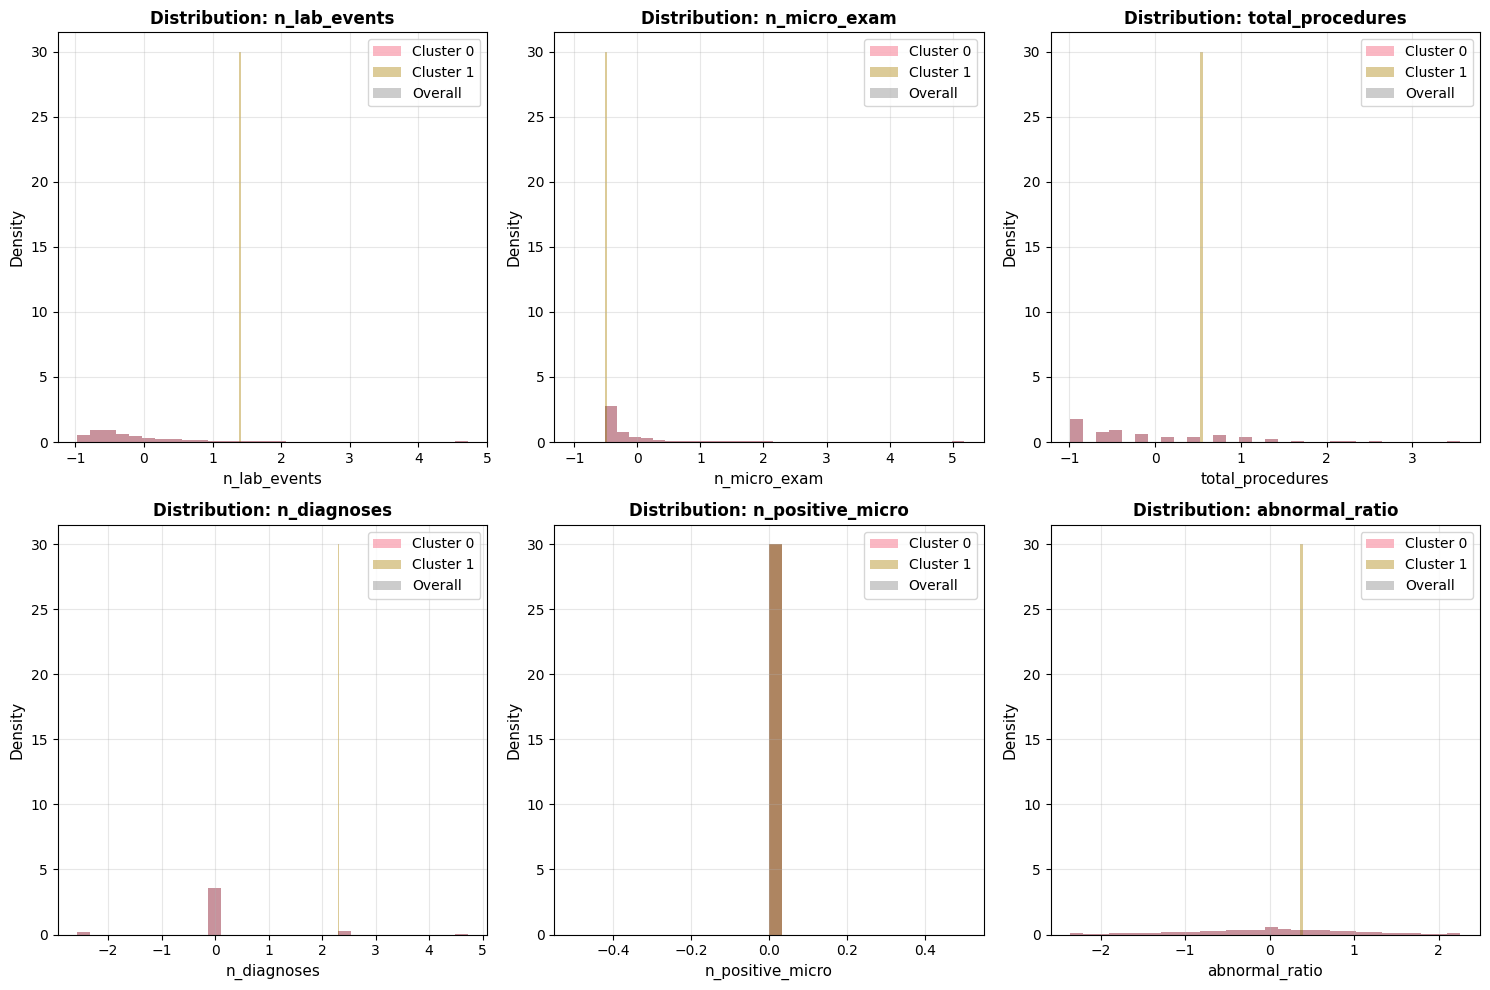

In [23]:
# Compare distributions: clusters vs overall
key_features = numeric_features[:6]  # Select first 6 features

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot distribution for each cluster
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id][feature]
        ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=30, density=True)
    
    # Plot overall distribution
    ax.hist(df_clustered[feature], alpha=0.2, color='black', 
           label='Overall', bins=30, density=True, linestyle='--', linewidth=2)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


### 2D Visualization using PCA


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


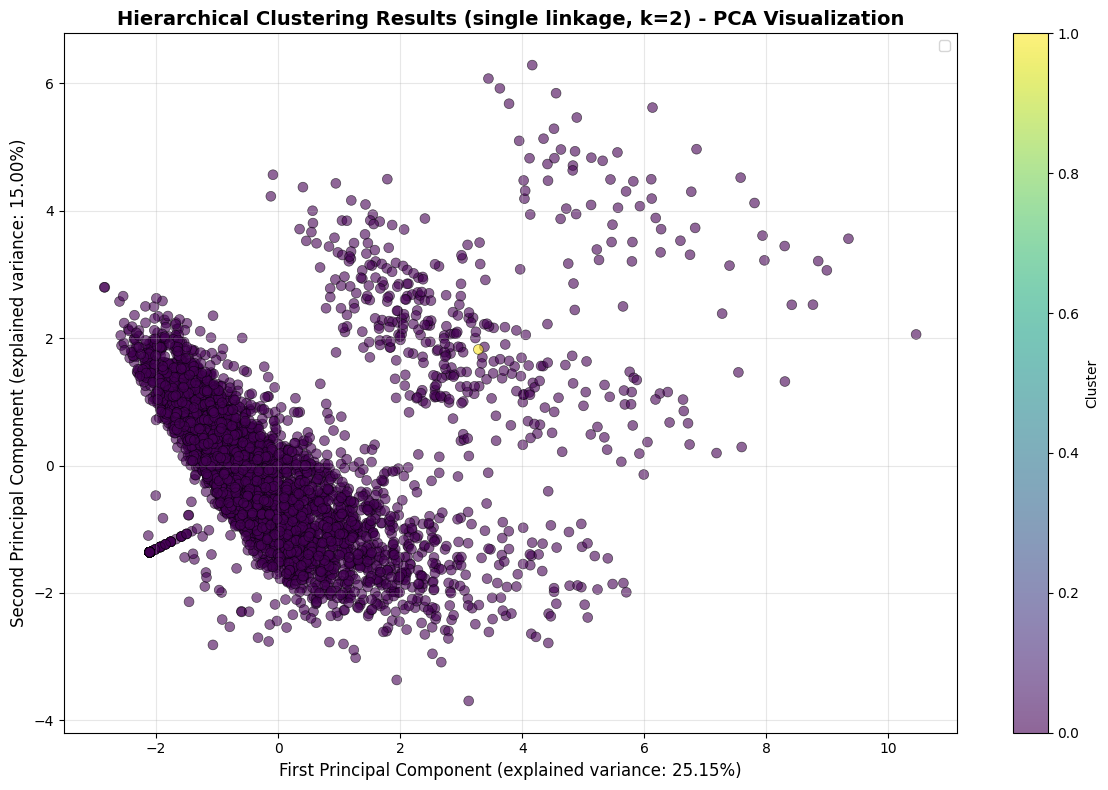

PCA explained variance ratio: [0.25148741 0.15001735]
Total explained variance: 40.15%


In [24]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                    cmap='viridis', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})', 
             fontsize=12)
ax.set_ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})', 
             fontsize=12)
ax.set_title(f'Hierarchical Clustering Results ({optimal_linkage} linkage, k={optimal_n_clusters}) - PCA Visualization', 
            fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")
